<div align="center"><h1>Control Engineering Basics</h1>
<br><b>Dr.Varodom Toochinda</b>
<br>Dept. of Mechanical Engineering, Kasetsart University</div>

### Solution to PID implementation exercise

<a href="https://colab.research.google.com/github/dewdotninja/control_python/blob/master/exercises/solutions/pid_implement_exercise_soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Requirement : </b> Python 3 with Python control systems library
<p />Execute the commands below to install Python control systems library in Colab    

In [ ]:
!pip install control

In [1]:
import control as ctl 
import numpy as np
import matplotlib.pyplot as plt

### Exercise

For the robot joint with DC motor transfer function

$$
P(s) = \frac{1}{10s^2+0.1s}
$$
and PID controller
$$
C(s) = K_p + \frac{K_i}{s} + \frac{NK_d}{N/s+1}
$$

we want to perform discrete-time simulation of the closed-loop system. The process of converting 
the plant to difference equation is provided. You only have to implement the PID controller.

#### Solution

In [2]:
s = ctl.tf("s")
P = 1/(10*s**2+0.1*s)
P

TransferFunction(array([1]), array([10. ,  0.1,  0. ]))

In [3]:
def PID(kp, ki,kd,N):
    s = ctl.tf("s")
    C = kp + ki/s + kd*s*N/(s+N)
    return C

Using this set of parameters to construct the controller.

In [4]:
Kp = 144
Ki = 20
Kd = 60
N = 100
C = PID(Kp,Ki,Kd,N)
C

TransferFunction(array([ 6144, 14420,  2000]), array([  1, 100,   0]))

Simulate the step response in continuous time to make sure that we get a stable closed-loop 
with acceptable performance

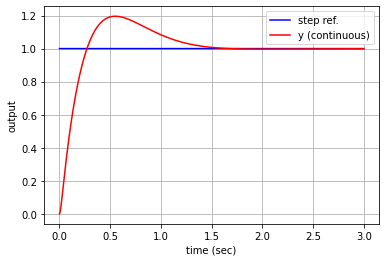

In [5]:
tvec = np.arange(0,3,0.001)
r = np.ones(tvec.shape)
L = C*P
sys = ctl.feedback(L)
tv, y = ctl.step_response(sys, tvec)

plt.figure()
plt.plot(tv,r,'b',tv,y,'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(['step ref.','y (continuous)'])
plt.show()

In [6]:
# Plant discretization
Ts = 0.001 # second
Pd = ctl.sample_system(P, Ts, method='tustin')
Pdnum, Pdden = ctl.tfdata(Pd)
pdnum = np.squeeze(np.array(Pdnum))
pdden = np.squeeze(np.array(Pdden))
px_size = len(pdden)  
px = np.zeros((px_size,1)) # plant state vector

Write your PID controller function in the cell below.

In [7]:
e_1 = 0
u_i1 = 0
u_d1 = 0
u_p0 = 0
u_i0 = 0
u_d0 = 0
u_0 = 0
e_0 = 0
# PID controller function
def PID_control(r,y): 
    global e_0,u_p0, u_i0, u_d0
    e_1 = e_0  # e_1 = e(k-1), e_0 = e(k)
    u_i1 = u_i0 # u_i1 = ui(k-1)
    u_d1 = u_d0 
    e_0 = r - y
    u_p0 = Kp*e_0
    u_i0 = u_i1 + 0.5*Ki*Ts*(e_0+e_1)
    u_d0 = -((N*Ts-2)/(2+N*Ts))*u_d1 + (2*Kd*N/(2+N*Ts))*(e_0-e_1)
    u_0 = u_p0 + u_i0 + u_d0
    return u_0


Code for discrete-time simulation 

In [8]:
tvec = np.arange(0,3,Ts) 
rvec = np.ones(tvec.shape)
yvec = np.zeros(tvec.shape)
uvec = np.zeros(tvec.shape)

In [12]:
i = 0
# reset plant states
for k in range(px_size):
    px[k] = 0
# initialize controller states
e_1 = 0
u_i1 = 0
u_d1 = 0
u_p0 = 0
u_i0 = 0
u_d0 = 0
u_0 = 0
e_0 = 0

# perform discrete-time simulation 
for i in range(len(tvec)):
    for k in range(px_size-1): # update plant states
        px[px_size-k-1] = px[px_size-k-2]

    if i==0:
        e = rvec[i]
    else:
        e = rvec[i] - yvec[i-1]

    # controller difference equation
    
    uvec[i] = PID_control(rvec[i],yvec[i-1])

    # plant difference equation
    px[0] = uvec[i]
    yvec[i] = pdnum[0]*uvec[i]
    for k in range(px_size-1):
        px[0] = px[0] -pdden[k+1]*px[k+1]
        yvec[i] = yvec[i] + (pdnum[k+1] - pdnum[0]*pdden[k+1])*px[k+1]

In [10]:
# continuous-time simulation. Same as above just repeated here for convenience.
L = C*P
sys = ctl.feedback(L)
tv, y = ctl.step_response(sys, tvec)

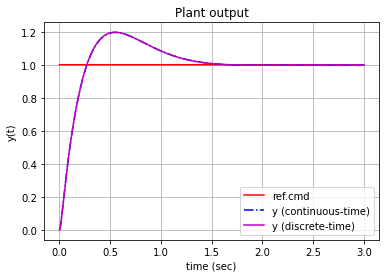

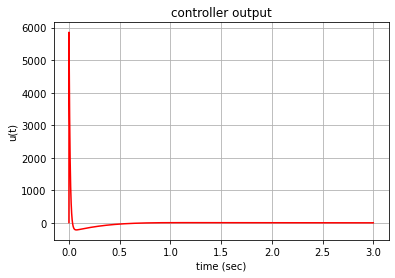

In [13]:
plt.figure()
plt.plot(tvec,rvec,'r-',tvec, y,'b-.',tvec,yvec,'m-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('y(t)')
plt.legend(['ref.cmd','y (continuous-time)','y (discrete-time)'])
plt.title("Plant output")
plt.show()

plt.figure()
plt.plot(tvec,uvec,'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('u(t)')
plt.title("controller output")
plt.show()

<div align="right">Last update : October 6, 2022</div>

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja<br>Copyright 2021</div>